In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import csv
import numpy
import os

In [3]:
import sys

In [4]:
sys.path.append('/home/grimur/git/nplinker/nplinker/prototype')

In [5]:
from nplinker import nplinker
from nplinker import logconfig
logconfig.LogConfig.setLogLevel('DEBUG')

In [6]:
nplinker_data_path = '/home/grimur/iokr_verify_data/gross.toml'
# gnps_spectrum_file = "/home/grimur/iokr_verify_data/crusemann/extracted/MSV000078836/clusterinfosummarygroup_attributes_withIDs_withcomponentID/b270f7e260f34e808ead3f642784b672.tsv"


In [7]:
npl = nplinker.NPLinker(nplinker_data_path)
npl.load_data()

11:01:18 [DEBUG] config.py:71, Parsing default config file: /home/grimur/.config/nplinker/nplinker.toml
11:01:18 [DEBUG] config.py:74, Loading user config /home/grimur/iokr_verify_data/gross.toml
11:01:18 [INFO] config.py:106, Loading from local data in directory /home/grimur/iokr_verify_data/gross
11:01:18 [DEBUG] loader.py:129, DatasetLoader(/home/grimur/iokr_verify_data/gross, , False)
11:01:18 [DEBUG] nplinker.py:119, Enabled scoring method: metcalf
11:01:18 [DEBUG] nplinker.py:119, Enabled scoring method: testscore
11:01:18 [DEBUG] nplinker.py:119, Enabled scoring method: rosetta
11:01:18 [DEBUG] nplinker.py:240, load_data (normal case, full load, met_only=False)
11:01:18 [WARNING] loader.py:31, WARNING: unable to find extra_nodes_file in path "/home/grimur/iokr_verify_data/gross/quantification_table_reformatted/*.csv"
11:01:18 [WARNING] loader.py:31, WARNING: unable to find metadata_table_file in path "/home/grimur/iokr_verify_data/gross/metadata_table/metadata_table*.txt"
11:01:

True

In [8]:
spectra_to_strains = {}
with open(gnps_spectrum_file, 'r') as f:
    r = csv.reader(f, delimiter="\t")
    header = next(r)
    id_column = header.index('cluster index')
    strain_columns = [x for x in range(len(header)) if header[x].startswith('C') and len(header[x]) == 6]
    for line in r:
        spectrum_id = line[id_column]
        member_strains = [header[x] for x in range(len(line)) if line[x] != '0' and x in strain_columns]
        spectra_to_strains[int(spectrum_id)] = member_strains
        

NameError: name 'gnps_spectrum_file' is not defined

In [9]:
# Assign known_cluster_blast hits to BGCs

In [10]:
from nplinker.parsers.kcb import KCBParser

In [11]:
kkb_bgc_hits = {}
for bgc in npl.bgcs:
    kcb_filename = KCBParser.get_kcb_filename_from_bgc(bgc)
    kcb_parser = KCBParser(kcb_filename)
    hits = []
    for mibig_id, hit in kcb_parser.hits.items():
        score = numpy.sum([x['blast_score'] for x in hit['individual_hits']])
        hits.append((mibig_id, score))
    if len(hits) > 0:
        kkb_bgc_hits[bgc] = hits

In [12]:
print(len(kkb_bgc_hits))

99


In [58]:
# Define the links to look for
# These are the links from the paired data platform - so, _verified_ links!!!

In [13]:
established_links = [
    ('GCF_001625105', 'BGC0000632', 603),  # brasilicardin A
    ('GCF_001625105', 'BGC0000632', 97),  # brasilicardin C
    ('GCF_001625105', 'BGC0001381', 116),  # brasilinolide A, nocardia terpenica
    ('GCF_000012445', 'BGC0001842', 3),  # pseudomonas fluorescens pf0-1
    ('GCF_001562525', 'BGC0000463', 3),  # pseudomonas putida
    # ('', 'BGC0000952', 13),
    ('GCF_002899455', 'BGC0001116', 947),  # Streptomyces virginiae -- only have one streptomyces, so assigning that...
    ('GCF_000012265', 'BGC0000399', 16),  # Pseudomonas protegens
    ('GCF_002899455', 'BGC0000296', 370),  # Streptomyces anulatus -- only have one...
    ('GCF_002899455', 'BGC0001298', 222),  # Streptomyces calvus -- only have one...
]

In [74]:
established_link_objects = []
established_link_objects_ids = []
for bgc, kkb_hits in kkb_bgc_hits.items():
    for strain_id, mibig_id, molfam_id in established_links:
        if strain_id == bgc.strain.id or strain_id in bgc.strain.aliases:
            if mibig_id in [x[0] for x in kkb_hits if x[1] > 10000]:
                for molecular_family in npl.molfams:
                    if molecular_family.family_id == molfam_id:
                        for spectrum in molecular_family.spectra:
                            spectrum_strain_ids = set([x.id for x in spectrum.strains])
                            for x in spectrum.strains:
                                spectrum_strain_ids = spectrum_strain_ids.union(x.aliases)
                            if strain_id not in spectrum_strain_ids:
                                continue
                            print(strain_id, mibig_id, spectrum.spectrum_id)
                            established_link_objects.append((bgc, spectrum))
                            established_link_objects_ids.append((bgc.name, spectrum.spectrum_id))

GCF_000012265 BGC0000399 9416
GCF_000012265 BGC0000399 9478
GCF_000012265 BGC0000399 9483
GCF_000012265 BGC0000399 9492
GCF_000012265 BGC0000399 9495
GCF_000012265 BGC0000399 9498
GCF_000012265 BGC0000399 9500
GCF_000012265 BGC0000399 9503
GCF_000012265 BGC0000399 9506
GCF_000012265 BGC0000399 9511
GCF_000012265 BGC0000399 9512
GCF_000012265 BGC0000399 9517
GCF_000012265 BGC0000399 9518
GCF_000012265 BGC0000399 9528
GCF_000012265 BGC0000399 9529
GCF_000012265 BGC0000399 9534
GCF_000012265 BGC0000399 9542
GCF_001625105 BGC0001381 7892
GCF_001625105 BGC0001381 8160
GCF_001625105 BGC0001381 8373
GCF_001625105 BGC0001381 8466
GCF_001625105 BGC0001381 8514
GCF_001625105 BGC0001381 8550
GCF_001625105 BGC0001381 8568
GCF_001625105 BGC0001381 8573
GCF_001625105 BGC0001381 8595
GCF_001625105 BGC0001381 8605
GCF_001625105 BGC0001381 8636
GCF_001625105 BGC0001381 8654
GCF_001625105 BGC0001381 8660
GCF_001625105 BGC0001381 8694
GCF_001625105 BGC0001381 8700
GCF_001625105 BGC0001381 8743
GCF_001625

In [75]:
print(len(established_link_objects))
print(len(established_link_objects_ids))

172
172


In [18]:
datapath = '/home/grimur/git/nplinker/nplinker/prototype/nplinker/scoring/iokr/data'

spectra = datapath + os.sep + "spectra.txt"
spectra_folder = datapath + os.sep + 'SPEC'

In [19]:
import spectrum_filters
spectrum_filters.datapath = datapath
import spectrum

In [20]:
test_set_spectra = []
for npl_s in npl.spectra:
    ms = spectrum.MSSpectrum()
    ms.correct_for_ionisation = True
    ms.normalise = True
    ms.filter = spectrum_filters.filter_by_frozen_dag
    ms.init_from_spec(npl_s)
    test_set_spectra.append((ms, npl_s.spectrum_id))
    

In [21]:
# Need the training data server to process the test word vecs!

In [22]:
import metabolite
metabolite_server = metabolite.MetaboliteServer()

['/home/grimur/miniconda2/envs/jupyter-py3/lib/python3.7/site-packages/cdk_pywrapper']
Server process already running: True


In [23]:
# load bgcs

In [24]:
import bgc

mibig_structure_file = "/home/grimur/_iokr/data/mibig/compunds_structures_1.4.csv"
pfs_data_dir = "/home/grimur/mibig_kernel_test/cache/pfs"

bgc_corpus = bgc.load_data_dir(mibig_structure_file, pfs_data_dir)


building word vectors from 2236 words


In [25]:
pfs_dir = '/home/grimur/iokr_verify_data/gross/bigscape/cache/pfs'


In [26]:
sum(bgc_corpus.to_wv(['PF00975.19']))

1

In [27]:
def read_bgc_domains(bgc_name):
    pfs_file = pfs_dir + os.sep + bgc_name + '.pfs'
    with open(pfs_file, 'r') as f:
        line = f.read()
        domains = line.split()
    return domains
    
wv = read_bgc_domains(npl.bgcs[0].name)
print(sum(bgc_corpus.to_wv(wv)))

52


In [28]:
test_set_bgcs = []
for bgc in npl.bgcs:
    domains = read_bgc_domains(bgc.name)
    wv = bgc_corpus.to_wv(domains)
    test_set_bgcs.append((wv, bgc.name))

In [29]:
# test_set_bgcs
# test_set_spectra
# established_link_objects_ids

In [30]:
bgc_list = bgc_corpus.documents

bgc_training_set_wv = []
bgc_training_set_metabolites = []
bgc_training_set_ids = []

count = 0
for bgc_item in bgc_list:
    count += 1
    # sort of expect 50% increase in success due to multiple structures for BGCs
    if count % 100 == 0:
        print('{} / {}, {} success'.format(count, len(bgc_list), len(bgc_training_set_metabolites)))
    for structure in bgc_item.metabolites:
        try:
            metabolite_server.add_metabolite(structure)
            success = True
        except:
            success = False

        if success:
            bgc_training_set_wv.append(bgc_item.word_vector)
            bgc_training_set_metabolites.append(structure)
            bgc_training_set_ids.append(bgc_item.bgc_id)



100 / 1200, 143 success
200 / 1200, 276 success
300 / 1200, 401 success
400 / 1200, 551 success
500 / 1200, 689 success
600 / 1200, 857 success
700 / 1200, 1009 success
800 / 1200, 1125 success
900 / 1200, 1236 success
1000 / 1200, 1373 success
1100 / 1200, 1540 success
1200 / 1200, 1682 success


In [31]:
import bgc

In [32]:
print('calculate kernel')
total = len(bgc_training_set_wv) ** 2 / 2
count = 0
K_z = numpy.zeros((len(bgc_training_set_wv), len(bgc_training_set_wv)))
for v1_idx in range(len(bgc_training_set_wv)):
    for v2_idx in range(v1_idx + 1):
        count += 1
        if count % 10000 == 0:
            print('{} / {}'.format(count, total))
        v1 = bgc_training_set_wv[v1_idx]
        v2 = bgc_training_set_wv[v2_idx]
        k_v1_v2 = bgc.wv_kernel(v1, v2)
        K_z[v1_idx, v2_idx] = k_v1_v2
        K_z[v2_idx, v1_idx] = k_v1_v2
    

calculate kernel
10000 / 1416244.5
20000 / 1416244.5
30000 / 1416244.5
40000 / 1416244.5
50000 / 1416244.5
60000 / 1416244.5
70000 / 1416244.5
80000 / 1416244.5
90000 / 1416244.5
100000 / 1416244.5
110000 / 1416244.5
120000 / 1416244.5
130000 / 1416244.5
140000 / 1416244.5
150000 / 1416244.5
160000 / 1416244.5
170000 / 1416244.5
180000 / 1416244.5
190000 / 1416244.5
200000 / 1416244.5
210000 / 1416244.5
220000 / 1416244.5
230000 / 1416244.5
240000 / 1416244.5
250000 / 1416244.5
260000 / 1416244.5
270000 / 1416244.5
280000 / 1416244.5
290000 / 1416244.5
300000 / 1416244.5
310000 / 1416244.5
320000 / 1416244.5
330000 / 1416244.5
340000 / 1416244.5
350000 / 1416244.5
360000 / 1416244.5
370000 / 1416244.5
380000 / 1416244.5
390000 / 1416244.5
400000 / 1416244.5
410000 / 1416244.5
420000 / 1416244.5
430000 / 1416244.5
440000 / 1416244.5
450000 / 1416244.5
460000 / 1416244.5
470000 / 1416244.5
480000 / 1416244.5
490000 / 1416244.5
500000 / 1416244.5
510000 / 1416244.5
520000 / 1416244.5
5300

In [33]:
# load training set spectra
import spectrum

In [34]:
ms2_objects = spectrum.load_data_dir(spectra, spectra_folder, spectrum_filters.filter_by_frozen_dag)

In [35]:
ms_training_set_ids = []
ms_training_set_spectra = []
ms_training_set_metabolites = []

count = 0
for ms_object in ms2_objects:
    count += 1
    if count % 100 == 0:
        print('{} / {}, {} success'.format(count, len(ms2_objects), len(ms_training_set_metabolites)))
    try:
        metabolite_server.add_metabolite(ms_object.metabolite)
        success = True
    except:
        success = False
    if success:
        ms_training_set_metabolites.append(ms_object.metabolite)
        ms_training_set_spectra.append(ms_object.spectrum)
        ms_training_set_ids.append(ms_object.spectrum_id)
    
print('calculate kernel')
total = len(ms_training_set_ids) ** 2 / 2
count = 0
K_x = numpy.zeros((len(ms_training_set_ids), len(ms_training_set_ids)))
for v1_idx in range(len(ms_training_set_spectra)):
    for v2_idx in range(v1_idx + 1):
        count += 1
        if count % 10000 == 0:
            print('{} / {}'.format(count, total))
        v1 = ms_training_set_spectra[v1_idx]
        v2 = ms_training_set_spectra[v2_idx]
        k_v1_v2 = spectrum.ppk_wrapper(v1, v2)
        K_x[v1_idx, v2_idx] = k_v1_v2
        K_x[v2_idx, v1_idx] = k_v1_v2

100 / 4138, 99 success
200 / 4138, 199 success
300 / 4138, 299 success
400 / 4138, 399 success
500 / 4138, 499 success
600 / 4138, 599 success
700 / 4138, 699 success
800 / 4138, 799 success
900 / 4138, 899 success
1000 / 4138, 999 success
1100 / 4138, 1099 success
1200 / 4138, 1199 success
1300 / 4138, 1299 success
1400 / 4138, 1399 success
1500 / 4138, 1499 success
1600 / 4138, 1599 success
1700 / 4138, 1699 success
1800 / 4138, 1799 success
1900 / 4138, 1899 success
2000 / 4138, 1999 success
2100 / 4138, 2099 success
2200 / 4138, 2199 success
2300 / 4138, 2299 success
2400 / 4138, 2399 success
2500 / 4138, 2499 success
2600 / 4138, 2599 success
2700 / 4138, 2699 success
2800 / 4138, 2799 success
2900 / 4138, 2899 success
3000 / 4138, 2999 success
3100 / 4138, 3099 success
3200 / 4138, 3199 success
3300 / 4138, 3299 success
3400 / 4138, 3399 success
3500 / 4138, 3499 success
3600 / 4138, 3599 success
3700 / 4138, 3699 success
3800 / 4138, 3799 success
3900 / 4138, 3899 success
4000 /

3630000 / 8561522.0
3640000 / 8561522.0
3650000 / 8561522.0
3660000 / 8561522.0
3670000 / 8561522.0
3680000 / 8561522.0
3690000 / 8561522.0
3700000 / 8561522.0
3710000 / 8561522.0
3720000 / 8561522.0
3730000 / 8561522.0
3740000 / 8561522.0
3750000 / 8561522.0
3760000 / 8561522.0
3770000 / 8561522.0
3780000 / 8561522.0
3790000 / 8561522.0
3800000 / 8561522.0
3810000 / 8561522.0
3820000 / 8561522.0
3830000 / 8561522.0
3840000 / 8561522.0
3850000 / 8561522.0
3860000 / 8561522.0
3870000 / 8561522.0
3880000 / 8561522.0
3890000 / 8561522.0
3900000 / 8561522.0
3910000 / 8561522.0
3920000 / 8561522.0
3930000 / 8561522.0
3940000 / 8561522.0
3950000 / 8561522.0
3960000 / 8561522.0
3970000 / 8561522.0
3980000 / 8561522.0
3990000 / 8561522.0
4000000 / 8561522.0
4010000 / 8561522.0
4020000 / 8561522.0
4030000 / 8561522.0
4040000 / 8561522.0
4050000 / 8561522.0
4060000 / 8561522.0
4070000 / 8561522.0
4080000 / 8561522.0
4090000 / 8561522.0
4100000 / 8561522.0
4110000 / 8561522.0
4120000 / 8561522.0


7730000 / 8561522.0
7740000 / 8561522.0
7750000 / 8561522.0
7760000 / 8561522.0
7770000 / 8561522.0
7780000 / 8561522.0
7790000 / 8561522.0
7800000 / 8561522.0
7810000 / 8561522.0
7820000 / 8561522.0
7830000 / 8561522.0
7840000 / 8561522.0
7850000 / 8561522.0
7860000 / 8561522.0
7870000 / 8561522.0
7880000 / 8561522.0
7890000 / 8561522.0
7900000 / 8561522.0
7910000 / 8561522.0
7920000 / 8561522.0
7930000 / 8561522.0
7940000 / 8561522.0
7950000 / 8561522.0
7960000 / 8561522.0
7970000 / 8561522.0
7980000 / 8561522.0
7990000 / 8561522.0
8000000 / 8561522.0
8010000 / 8561522.0
8020000 / 8561522.0
8030000 / 8561522.0
8040000 / 8561522.0
8050000 / 8561522.0
8060000 / 8561522.0
8070000 / 8561522.0
8080000 / 8561522.0
8090000 / 8561522.0
8100000 / 8561522.0
8110000 / 8561522.0
8120000 / 8561522.0
8130000 / 8561522.0
8140000 / 8561522.0
8150000 / 8561522.0
8160000 / 8561522.0
8170000 / 8561522.0
8180000 / 8561522.0
8190000 / 8561522.0
8200000 / 8561522.0
8210000 / 8561522.0
8220000 / 8561522.0


In [36]:
import molecular_fingerprints

In [37]:
K_y = numpy.zeros((len(ms_training_set_ids), len(bgc_training_set_ids)))

total = len(ms_training_set_ids) * len(bgc_training_set_ids)
count = 0
for i in range(len(ms_training_set_ids)):
    for j in range(len(bgc_training_set_ids)):
        count += 1
        if count % 10000 == 0:
            print('{} / {}'.format(count, total))
        structure_1 = ms_training_set_metabolites[i]
        structure_2 = bgc_training_set_metabolites[j]
        fp1 = metabolite_server.get_metabolite(structure_1)['fingerprint']
        fp2 = metabolite_server.get_metabolite(structure_2)['fingerprint']
        k_fp1_fp2 = molecular_fingerprints.fingerprint_kernel(fp1, fp2)
        K_y[i, j] = k_fp1_fp2

10000 / 6964254
20000 / 6964254
30000 / 6964254
40000 / 6964254
50000 / 6964254
60000 / 6964254
70000 / 6964254
80000 / 6964254
90000 / 6964254
100000 / 6964254
110000 / 6964254
120000 / 6964254
130000 / 6964254
140000 / 6964254
150000 / 6964254
160000 / 6964254
170000 / 6964254
180000 / 6964254
190000 / 6964254
200000 / 6964254
210000 / 6964254
220000 / 6964254
230000 / 6964254
240000 / 6964254
250000 / 6964254
260000 / 6964254
270000 / 6964254
280000 / 6964254
290000 / 6964254
300000 / 6964254
310000 / 6964254
320000 / 6964254
330000 / 6964254
340000 / 6964254
350000 / 6964254
360000 / 6964254
370000 / 6964254
380000 / 6964254
390000 / 6964254
400000 / 6964254
410000 / 6964254
420000 / 6964254
430000 / 6964254
440000 / 6964254
450000 / 6964254
460000 / 6964254
470000 / 6964254
480000 / 6964254
490000 / 6964254
500000 / 6964254
510000 / 6964254
520000 / 6964254
530000 / 6964254
540000 / 6964254
550000 / 6964254
560000 / 6964254
570000 / 6964254
580000 / 6964254
590000 / 6964254
600000

4630000 / 6964254
4640000 / 6964254
4650000 / 6964254
4660000 / 6964254
4670000 / 6964254
4680000 / 6964254
4690000 / 6964254
4700000 / 6964254
4710000 / 6964254
4720000 / 6964254
4730000 / 6964254
4740000 / 6964254
4750000 / 6964254
4760000 / 6964254
4770000 / 6964254
4780000 / 6964254
4790000 / 6964254
4800000 / 6964254
4810000 / 6964254
4820000 / 6964254
4830000 / 6964254
4840000 / 6964254
4850000 / 6964254
4860000 / 6964254
4870000 / 6964254
4880000 / 6964254
4890000 / 6964254
4900000 / 6964254
4910000 / 6964254
4920000 / 6964254
4930000 / 6964254
4940000 / 6964254
4950000 / 6964254
4960000 / 6964254
4970000 / 6964254
4980000 / 6964254
4990000 / 6964254
5000000 / 6964254
5010000 / 6964254
5020000 / 6964254
5030000 / 6964254
5040000 / 6964254
5050000 / 6964254
5060000 / 6964254
5070000 / 6964254
5080000 / 6964254
5090000 / 6964254
5100000 / 6964254
5110000 / 6964254
5120000 / 6964254
5130000 / 6964254
5140000 / 6964254
5150000 / 6964254
5160000 / 6964254
5170000 / 6964254
5180000 / 

In [38]:
# Create mechanism to build the test sample kernel vectors

In [39]:
import iokr_data_server

In [40]:
data_server = iokr_data_server.IOKRDataServer()

In [41]:
data_server.data_set_x = ms_training_set_spectra
data_server.data_set_x_ids = ms_training_set_ids
data_server.kernel_function_x = spectrum.ppk_wrapper
data_server.K_x = K_x

data_server.K_y = K_y

data_server.data_set_z = bgc_training_set_wv
data_server.data_set_z_ids = bgc_training_set_ids
data_server.kernel_function_z = bgc.wv_kernel
data_server.K_z = K_z

data_server.data_type_x = type(ms_training_set_spectra[0])
data_server.data_type_z = type(bgc_training_set_wv[0])

In [42]:
# init IOKR server

In [43]:
import iokr_server

In [44]:
iokr = iokr_server.IOKRServer()

iokr._lambda = 0.1

iokr.training_data_x = ms_training_set_spectra
iokr.training_data_z = bgc_training_set_wv

iokr.K_x = K_x
iokr.K_y = K_y
iokr.K_z = K_z

iokr.init()

In [45]:
# test_set_bgcs
# test_set_spectra
# established_link_objects_ids
import time

In [46]:
score_matrix = numpy.zeros((len(test_set_spectra), len(test_set_bgcs)))
count = 0
total = len(test_set_spectra) * len(test_set_bgcs)
K_x_inv = iokr.K_x_inv
K_y = iokr.K_y
K_z_inv = iokr.K_z_inv
t0 = time.time()
for s_idx, (s_obj, s_id) in enumerate(test_set_spectra):
    s_id = str(s_id)
    x_kernel_vector = data_server.kernel_vector(s_obj, s_id)
    for b_idx, (b_obj, b_id) in enumerate(test_set_bgcs):
        count += 1
        if count % 1000 == 0:
            remaining = total - count
            t1 = time.time()
            time_per_sample = (t1 - t0) / 1000
            projected_time_sec = remaining * time_per_sample
            projected_min = projected_time_sec / 60
            projected_hrs = projected_min / 60
            projected_days = projected_hrs / 24
            #print(projected_time_sec)
            print('{} / {}, projected {} days, {}:{}'.format(
                count, 
                total, 
                int(projected_days), 
                int(projected_hrs) % 24, 
                int(projected_min) % 60))
            t0 = time.time()
        z_kernel_vector = data_server.kernel_vector(b_obj, b_id)

        score = iokr_server.score_vector(x_kernel_vector, z_kernel_vector, K_x_inv, K_y, K_z_inv)
        score_matrix[s_idx, b_idx] = score


1000 / 1256683, projected 0 days, 18:44
2000 / 1256683, projected 0 days, 3:16
3000 / 1256683, projected 0 days, 3:9
4000 / 1256683, projected 0 days, 3:15
5000 / 1256683, projected 0 days, 3:15
6000 / 1256683, projected 0 days, 3:8
7000 / 1256683, projected 0 days, 3:16
8000 / 1256683, projected 0 days, 3:15
9000 / 1256683, projected 0 days, 3:9
10000 / 1256683, projected 0 days, 3:15
11000 / 1256683, projected 0 days, 3:9
12000 / 1256683, projected 0 days, 3:14
13000 / 1256683, projected 0 days, 3:14
14000 / 1256683, projected 0 days, 3:9
15000 / 1256683, projected 0 days, 3:14
16000 / 1256683, projected 0 days, 3:14
17000 / 1256683, projected 0 days, 3:9
18000 / 1256683, projected 0 days, 3:17
19000 / 1256683, projected 0 days, 3:19
20000 / 1256683, projected 0 days, 3:9
21000 / 1256683, projected 0 days, 3:21
22000 / 1256683, projected 0 days, 3:9
23000 / 1256683, projected 0 days, 3:15
24000 / 1256683, projected 0 days, 3:21
25000 / 1256683, projected 0 days, 3:10
26000 / 1256683,

205000 / 1256683, projected 0 days, 3:7
206000 / 1256683, projected 0 days, 3:7
207000 / 1256683, projected 0 days, 3:4
208000 / 1256683, projected 0 days, 2:59
209000 / 1256683, projected 0 days, 3:7
210000 / 1256683, projected 0 days, 3:9
211000 / 1256683, projected 0 days, 2:57
212000 / 1256683, projected 0 days, 3:10
213000 / 1256683, projected 0 days, 3:4
214000 / 1256683, projected 0 days, 3:3
215000 / 1256683, projected 0 days, 3:5
216000 / 1256683, projected 0 days, 3:1
217000 / 1256683, projected 0 days, 3:5
218000 / 1256683, projected 0 days, 3:3
219000 / 1256683, projected 0 days, 2:58
220000 / 1256683, projected 0 days, 3:6
221000 / 1256683, projected 0 days, 3:5
222000 / 1256683, projected 0 days, 3:3
223000 / 1256683, projected 0 days, 3:7
224000 / 1256683, projected 0 days, 3:3
225000 / 1256683, projected 0 days, 3:2
226000 / 1256683, projected 0 days, 3:6
227000 / 1256683, projected 0 days, 3:1
228000 / 1256683, projected 0 days, 3:5
229000 / 1256683, projected 0 days, 

406000 / 1256683, projected 0 days, 2:24
407000 / 1256683, projected 0 days, 2:19
408000 / 1256683, projected 0 days, 2:25
409000 / 1256683, projected 0 days, 2:28
410000 / 1256683, projected 0 days, 2:22
411000 / 1256683, projected 0 days, 2:28
412000 / 1256683, projected 0 days, 2:28
413000 / 1256683, projected 0 days, 2:22
414000 / 1256683, projected 0 days, 2:27
415000 / 1256683, projected 0 days, 2:16
416000 / 1256683, projected 0 days, 2:20
417000 / 1256683, projected 0 days, 2:22
418000 / 1256683, projected 0 days, 2:16
419000 / 1256683, projected 0 days, 2:21
420000 / 1256683, projected 0 days, 2:22
421000 / 1256683, projected 0 days, 2:16
422000 / 1256683, projected 0 days, 2:22
423000 / 1256683, projected 0 days, 2:20
424000 / 1256683, projected 0 days, 2:14
425000 / 1256683, projected 0 days, 2:19
426000 / 1256683, projected 0 days, 2:15
427000 / 1256683, projected 0 days, 2:19
428000 / 1256683, projected 0 days, 2:18
429000 / 1256683, projected 0 days, 2:14
430000 / 1256683

607000 / 1256683, projected 0 days, 1:44
608000 / 1256683, projected 0 days, 1:44
609000 / 1256683, projected 0 days, 1:41
610000 / 1256683, projected 0 days, 1:44
611000 / 1256683, projected 0 days, 1:44
612000 / 1256683, projected 0 days, 1:40
613000 / 1256683, projected 0 days, 1:44
614000 / 1256683, projected 0 days, 1:44
615000 / 1256683, projected 0 days, 1:41
616000 / 1256683, projected 0 days, 1:43
617000 / 1256683, projected 0 days, 1:39
618000 / 1256683, projected 0 days, 1:42
619000 / 1256683, projected 0 days, 1:43
620000 / 1256683, projected 0 days, 1:38
621000 / 1256683, projected 0 days, 1:43
622000 / 1256683, projected 0 days, 1:43
623000 / 1256683, projected 0 days, 1:39
624000 / 1256683, projected 0 days, 1:42
625000 / 1256683, projected 0 days, 1:37
626000 / 1256683, projected 0 days, 1:41
627000 / 1256683, projected 0 days, 1:42
628000 / 1256683, projected 0 days, 1:37
629000 / 1256683, projected 0 days, 1:41
630000 / 1256683, projected 0 days, 1:41
631000 / 1256683

807000 / 1256683, projected 0 days, 1:12
808000 / 1256683, projected 0 days, 1:10
809000 / 1256683, projected 0 days, 1:12
810000 / 1256683, projected 0 days, 1:12
811000 / 1256683, projected 0 days, 1:9
812000 / 1256683, projected 0 days, 1:11
813000 / 1256683, projected 0 days, 1:11
814000 / 1256683, projected 0 days, 1:9
815000 / 1256683, projected 0 days, 1:11
816000 / 1256683, projected 0 days, 1:11
817000 / 1256683, projected 0 days, 1:8
818000 / 1256683, projected 0 days, 1:11
819000 / 1256683, projected 0 days, 1:8
820000 / 1256683, projected 0 days, 1:10
821000 / 1256683, projected 0 days, 1:10
822000 / 1256683, projected 0 days, 1:8
823000 / 1256683, projected 0 days, 1:10
824000 / 1256683, projected 0 days, 1:9
825000 / 1256683, projected 0 days, 1:7
826000 / 1256683, projected 0 days, 1:9
827000 / 1256683, projected 0 days, 1:7
828000 / 1256683, projected 0 days, 1:10
829000 / 1256683, projected 0 days, 1:9
830000 / 1256683, projected 0 days, 1:7
831000 / 1256683, projected

1009000 / 1256683, projected 0 days, 0:40
1010000 / 1256683, projected 0 days, 0:38
1011000 / 1256683, projected 0 days, 0:39
1012000 / 1256683, projected 0 days, 0:39
1013000 / 1256683, projected 0 days, 0:38
1014000 / 1256683, projected 0 days, 0:39
1015000 / 1256683, projected 0 days, 0:39
1016000 / 1256683, projected 0 days, 0:37
1017000 / 1256683, projected 0 days, 0:38
1018000 / 1256683, projected 0 days, 0:37
1019000 / 1256683, projected 0 days, 0:38
1020000 / 1256683, projected 0 days, 0:38
1021000 / 1256683, projected 0 days, 0:36
1022000 / 1256683, projected 0 days, 0:38
1023000 / 1256683, projected 0 days, 0:38
1024000 / 1256683, projected 0 days, 0:36
1025000 / 1256683, projected 0 days, 0:37
1026000 / 1256683, projected 0 days, 0:37
1027000 / 1256683, projected 0 days, 0:35
1028000 / 1256683, projected 0 days, 0:36
1029000 / 1256683, projected 0 days, 0:35
1030000 / 1256683, projected 0 days, 0:36
1031000 / 1256683, projected 0 days, 0:36
1032000 / 1256683, projected 0 day

1205000 / 1256683, projected 0 days, 0:8
1206000 / 1256683, projected 0 days, 0:8
1207000 / 1256683, projected 0 days, 0:7
1208000 / 1256683, projected 0 days, 0:7
1209000 / 1256683, projected 0 days, 0:7
1210000 / 1256683, projected 0 days, 0:7
1211000 / 1256683, projected 0 days, 0:7
1212000 / 1256683, projected 0 days, 0:6
1213000 / 1256683, projected 0 days, 0:7
1214000 / 1256683, projected 0 days, 0:6
1215000 / 1256683, projected 0 days, 0:6
1216000 / 1256683, projected 0 days, 0:6
1217000 / 1256683, projected 0 days, 0:6
1218000 / 1256683, projected 0 days, 0:6
1219000 / 1256683, projected 0 days, 0:6
1220000 / 1256683, projected 0 days, 0:5
1221000 / 1256683, projected 0 days, 0:5
1222000 / 1256683, projected 0 days, 0:5
1223000 / 1256683, projected 0 days, 0:5
1224000 / 1256683, projected 0 days, 0:5
1225000 / 1256683, projected 0 days, 0:5
1226000 / 1256683, projected 0 days, 0:4
1227000 / 1256683, projected 0 days, 0:4
1228000 / 1256683, projected 0 days, 0:4
1229000 / 125668

In [47]:
import pickle
with open('gross_full_iokr.bin', 'wb') as f:
    pickle.dump(score_matrix, f)

In [48]:
# test_set_spectra = s_obj, s_id
# test_set_bgc = b_obj, b_id
# score = score_matrix[spectrum_idx, bgc_idx]


In [49]:
import numpy


In [76]:
established_bgc_names = [x[0] for x in established_link_objects_ids]
established_spectra_ids = [x[1] for x in established_link_objects_ids]
count = 0
gcf_mf_validated = set([])
for g in npl.gcfs:
    for b in g.bgcs:
        for m in npl.molfams:
            for s in m.spectra:
                if (b.name, s.spectrum_id) in established_link_objects_ids:
                    gcf_mf_validated.add((g.id, m.id))
                    count += 1
print(count)
print(gcf_mf_validated)
print(len(gcf_mf_validated))

172
{(41, 5774), (0, 6479), (22, 5804), (53, 6505), (90, 2533)}
5


In [77]:
test_set_bgc_ids = [x[1] for x in test_set_bgcs]
test_set_spectra_ids = [x[1] for x in test_set_spectra]

iokr_scores_all = []
iokr_scores_validated = []

count = 0
for g in npl.gcfs:
    for m in npl.molfams:
        count += 1
        if count % 1000 == 0:
            print("{} / {}".format(count, len(npl.gcfs) * len(npl.molfams)))
        link_score = -100
        for b in g.bgcs:
            b_idx = test_set_bgc_ids.index(b.name)
            for s in m.spectra:
                s_idx = test_set_spectra_ids.index(s.spectrum_id)
                score = score_matrix[s_idx, b_idx]
                link_score = max(score, link_score)
        iokr_scores_all.append(link_score)
        # validated
        if (g.id, m.id) in gcf_mf_validated:
            iokr_scores_validated.append(link_score)


1000 / 782160
2000 / 782160
3000 / 782160
4000 / 782160
5000 / 782160
6000 / 782160
7000 / 782160
8000 / 782160
9000 / 782160
10000 / 782160
11000 / 782160
12000 / 782160
13000 / 782160
14000 / 782160
15000 / 782160
16000 / 782160
17000 / 782160
18000 / 782160
19000 / 782160
20000 / 782160
21000 / 782160
22000 / 782160
23000 / 782160
24000 / 782160
25000 / 782160
26000 / 782160
27000 / 782160
28000 / 782160
29000 / 782160
30000 / 782160
31000 / 782160
32000 / 782160
33000 / 782160
34000 / 782160
35000 / 782160
36000 / 782160
37000 / 782160
38000 / 782160
39000 / 782160
40000 / 782160
41000 / 782160
42000 / 782160
43000 / 782160
44000 / 782160
45000 / 782160
46000 / 782160
47000 / 782160
48000 / 782160
49000 / 782160
50000 / 782160
51000 / 782160
52000 / 782160
53000 / 782160
54000 / 782160
55000 / 782160
56000 / 782160
57000 / 782160
58000 / 782160
59000 / 782160
60000 / 782160
61000 / 782160
62000 / 782160
63000 / 782160
64000 / 782160
65000 / 782160
66000 / 782160
67000 / 782160
6800

520000 / 782160
521000 / 782160
522000 / 782160
523000 / 782160
524000 / 782160
525000 / 782160
526000 / 782160
527000 / 782160
528000 / 782160
529000 / 782160
530000 / 782160
531000 / 782160
532000 / 782160
533000 / 782160
534000 / 782160
535000 / 782160
536000 / 782160
537000 / 782160
538000 / 782160
539000 / 782160
540000 / 782160
541000 / 782160
542000 / 782160
543000 / 782160
544000 / 782160
545000 / 782160
546000 / 782160
547000 / 782160
548000 / 782160
549000 / 782160
550000 / 782160
551000 / 782160
552000 / 782160
553000 / 782160
554000 / 782160
555000 / 782160
556000 / 782160
557000 / 782160
558000 / 782160
559000 / 782160
560000 / 782160
561000 / 782160
562000 / 782160
563000 / 782160
564000 / 782160
565000 / 782160
566000 / 782160
567000 / 782160
568000 / 782160
569000 / 782160
570000 / 782160
571000 / 782160
572000 / 782160
573000 / 782160
574000 / 782160
575000 / 782160
576000 / 782160
577000 / 782160
578000 / 782160
579000 / 782160
580000 / 782160
581000 / 782160
582000 /

In [78]:
len(iokr_scores_validated)

5

In [79]:
perc = numpy.percentile(iokr_scores_all, 95)
percentile_size = len([x for x in iokr_scores_all if x > perc])
percentile_validated_size = len([x for x in iokr_scores_validated if x > perc])
print('all:', len(iokr_scores_validated) / len(iokr_scores_all))
print('perc:', percentile_validated_size / percentile_size)

all: 6.392553953155365e-06
perc: 2.557021581262146e-05


In [80]:
import scipy

In [81]:

print('total size:', len(iokr_scores_all))
print('valid size:', len(iokr_scores_validated))
print('perc size:', percentile_size)
print('valid perc size:', percentile_validated_size)
contingency_table = numpy.array([
    [len(iokr_scores_all), len(iokr_scores_validated)],
    [percentile_size, percentile_validated_size]
])
print('p-val:', scipy.stats.fisher_exact(contingency_table))

total size: 782160
valid size: 5
perc size: 39108
valid perc size: 1
p-val: (4.0, 0.2537893732883249)


In [84]:
perc = numpy.percentile(iokr_scores_all, 90)
percentile_size = len([x for x in iokr_scores_all if x > perc])
percentile_validated_size = len([x for x in iokr_scores_validated if x > perc])
print('all:', len(iokr_scores_validated) / len(iokr_scores_all))
print('perc:', percentile_validated_size / percentile_size)

all: 6.392553953155365e-06
perc: 1.278510790631073e-05


In [85]:

print('total size:', len(iokr_scores_all))
print('valid size:', len(iokr_scores_validated))
print('perc size:', percentile_size)
print('valid perc size:', percentile_validated_size)
contingency_table = numpy.array([
    [len(iokr_scores_all), len(iokr_scores_validated)],
    [percentile_size, percentile_validated_size]
])
print('p-val:', scipy.stats.fisher_exact(contingency_table))

total size: 782160
valid size: 5
perc size: 78216
valid perc size: 1
p-val: (2.0, 0.4355290213817167)


In [90]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import seaborn as sns
sns.set()

/home/grimur/miniconda2/envs/jupyter-py3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


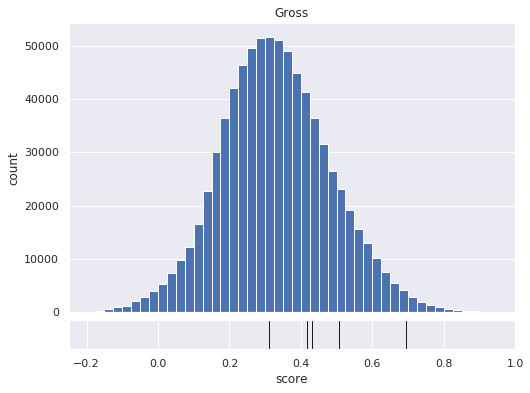

In [93]:
fig = plt.figure(figsize=(8, 6))


# ax_min = -0.15
ax_min = -0.25
# ax_max = 0.35
ax_max = 1.0

gs = gridspec.GridSpec(2, 1, height_ratios=[20, 2], hspace=0.05)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax1.set_title('Gross')

ax1.hist(iokr_scores_all, bins=50, range=[ax_min, ax_max])

ax2.plot(iokr_scores_validated, [5000]*len(iokr_scores_validated), '|', color='k', markersize=50)
ax1.set_xlim([ax_min, ax_max])
ax2.set_xlim([ax_min, ax_max])
ax1.set_xticks([])
ax2.set_yticks([])

ax1.set_ylabel('count')
ax2.set_xlabel('score')

plt.tight_layout()

plt.savefig('combined_iokr_hist_gross.pdf')

In [ ]:
# combined counts for all data sets (combined IOKR model)

In [86]:
total_verified = 15+8+5
total_all = 1404676+9900+782160
perc95_verified = 4+3+1
perc95_all = 70234+495+39108
perc90_verified = 7+3+1
perc90_all = 140468+990+78126

cont95 = numpy.array([
    [total_verified, total_all],
    [perc95_verified, perc95_all]
])
p95 = scipy.stats.fisher_exact(cont95)[1]

cont90 = numpy.array([
    [total_verified, total_all],
    [perc90_verified, perc90_all]
])
p90 = scipy.stats.fisher_exact(cont90)[1]

print('total size:', total_all)
print('valid size:', total_verified)
print('perc95 size:', perc95_all)
print('perc95 valid size:', perc95_verified)
print('perc95 pval:', p95)
print('perc90 size:', perc90_all)
print('perc90 valid size:', perc90_verified)
print('perc90 pval:', p90)

total size: 2196736
valid size: 28
perc95 size: 109837
perc95 valid size: 8
perc95 pval: 0.00024074296384751393
perc90 size: 219584
perc90 valid size: 11
perc90 pval: 0.0005249551942179976


In [71]:
15/999362

1.5009576109557898e-05

In [ ]:
# Complementarity of scores

In [94]:
from nplinker.scoring import misc

In [95]:
strains = npl.strains

In [96]:
test_set_bgc_ids = [x[1] for x in test_set_bgcs]
test_set_spectra_ids = [x[1] for x in test_set_spectra]

iokr_scores_all = []
iokr_scores_validated = []
corr_scores_all = []
corr_scores_validated = []

count = 0
for g in npl.gcfs:
    for m in npl.molfams:
        count += 1
        if count % 1000 == 0:
            print("{} / {}".format(count, len(npl.gcfs) * len(npl.molfams)))
        link_score = -100
        for b in g.bgcs:
            b_idx = test_set_bgc_ids.index(b.name)
            for s in m.spectra:
                s_idx = test_set_spectra_ids.index(s.spectrum_id)
                score = score_matrix[s_idx, b_idx]
                link_score = max(score, link_score)
        iokr_scores_all.append(link_score)
        corr_score = misc.metcalf_scoring(m, g, strains, standardised=True)
        corr_scores_all.append(corr_score)
        # validated
        if (g.id, m.id) in gcf_mf_validated:
            iokr_scores_validated.append(link_score)
            corr_scores_validated.append(corr_score)

1000 / 782160
2000 / 782160
3000 / 782160
4000 / 782160
5000 / 782160
6000 / 782160
7000 / 782160
8000 / 782160
9000 / 782160
10000 / 782160
11000 / 782160
12000 / 782160
13000 / 782160
14000 / 782160
15000 / 782160
16000 / 782160
17000 / 782160
18000 / 782160
19000 / 782160
20000 / 782160
21000 / 782160
22000 / 782160
23000 / 782160
24000 / 782160
25000 / 782160
26000 / 782160
27000 / 782160
28000 / 782160
29000 / 782160
30000 / 782160
31000 / 782160
32000 / 782160
33000 / 782160
34000 / 782160
35000 / 782160
36000 / 782160
37000 / 782160
38000 / 782160
39000 / 782160
40000 / 782160
41000 / 782160
42000 / 782160
43000 / 782160
44000 / 782160
45000 / 782160
46000 / 782160
47000 / 782160
48000 / 782160
49000 / 782160
50000 / 782160
51000 / 782160
52000 / 782160
53000 / 782160
54000 / 782160
55000 / 782160
56000 / 782160
57000 / 782160
58000 / 782160
59000 / 782160
60000 / 782160
61000 / 782160
62000 / 782160
63000 / 782160
64000 / 782160
65000 / 782160
66000 / 782160
67000 / 782160
6800

521000 / 782160
522000 / 782160
523000 / 782160
524000 / 782160
525000 / 782160
526000 / 782160
527000 / 782160
528000 / 782160
529000 / 782160
530000 / 782160
531000 / 782160
532000 / 782160
533000 / 782160
534000 / 782160
535000 / 782160
536000 / 782160
537000 / 782160
538000 / 782160
539000 / 782160
540000 / 782160
541000 / 782160
542000 / 782160
543000 / 782160
544000 / 782160
545000 / 782160
546000 / 782160
547000 / 782160
548000 / 782160
549000 / 782160
550000 / 782160
551000 / 782160
552000 / 782160
553000 / 782160
554000 / 782160
555000 / 782160
556000 / 782160
557000 / 782160
558000 / 782160
559000 / 782160
560000 / 782160
561000 / 782160
562000 / 782160
563000 / 782160
564000 / 782160
565000 / 782160
566000 / 782160
567000 / 782160
568000 / 782160
569000 / 782160
570000 / 782160
571000 / 782160
572000 / 782160
573000 / 782160
574000 / 782160
575000 / 782160
576000 / 782160
577000 / 782160
578000 / 782160
579000 / 782160
580000 / 782160
581000 / 782160
582000 / 782160
583000 /

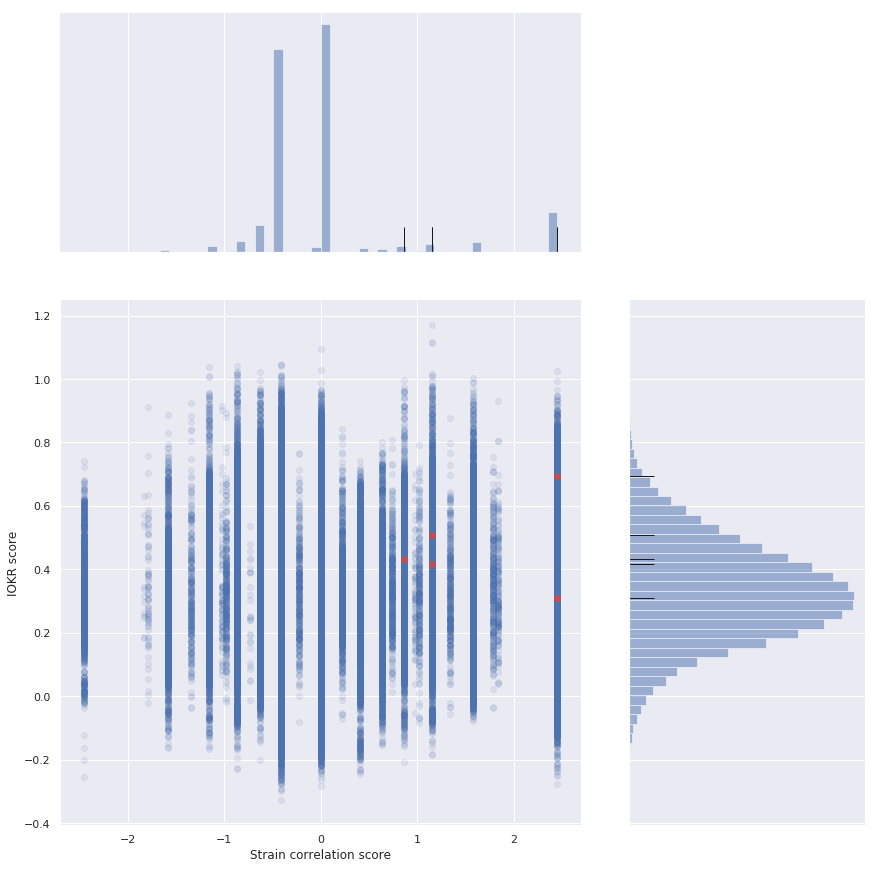

In [97]:
# Fig. for SI

all_score_pairs = list(zip(corr_scores_all, iokr_scores_all))
verified_score_pairs = list(zip(corr_scores_validated, iokr_scores_validated))

col1 = [x[0] for x in all_score_pairs if x[1] != -100]
col2 = [x[1] for x in all_score_pairs if x[1] != -100]


plot = sns.jointplot(col1, col2, alpha=0.1, ratio=2, height=12, marginal_kws={'hist_kws': {'alpha': 0.5}})
plot.ax_joint.plot([x[0] for x in verified_score_pairs if x[1] != -100], [x[1] for x in verified_score_pairs if x[1] != -100], 'ro', color='r')
# bc horizontal, flip x and y axis
plot.ax_marg_y.plot([0]*len(iokr_scores_validated), iokr_scores_validated, '|', color='k', marker=(2, 0, 90), markersize=50)
plot.ax_marg_x.plot(corr_scores_validated, [0]*len(corr_scores_validated), '|', color='k', markersize=50)


#plot.set_axis_labels('Standardised strain correlation score', 'IOKR score', size='large')
plot.set_axis_labels('Strain correlation score', 'IOKR score')


filename = '20210604_graph_combined_data_iokr_metcalf_gross'
plot.savefig(filename + '.png') #, dpi=1200)

In [98]:
# Validated links above 90 and 95 percentile

In [103]:
percentile_cutoff = 90

all_score_pairs = list(zip(corr_scores_all, iokr_scores_all))
verified_score_pairs = list(zip(corr_scores_validated, iokr_scores_validated))

iokr_percentile = numpy.percentile(iokr_scores_all, percentile_cutoff)
corr_percentile = numpy.percentile(corr_scores_all, percentile_cutoff)

iokr_valid_top = len([x for x in iokr_scores_validated if x >= iokr_percentile])
iokr_all_top = len([x for x in iokr_scores_all if x >= iokr_percentile])

corr_valid_top = len([x for x in corr_scores_validated if x >= corr_percentile])
corr_all_top = len([x for x in corr_scores_all if x >= corr_percentile])

both_valid_top = len([x for x, y in verified_score_pairs if x >= corr_percentile and y >= iokr_percentile])
both_all_top = len([x for x, y in all_score_pairs if x >= corr_percentile and y >= iokr_percentile])

print('all verified {}'.format(len(verified_score_pairs)))
print('all total {}'.format(len(all_score_pairs)))
print('all ratio {}'.format(len(verified_score_pairs) / len(all_score_pairs)))
print('iokr verified {}'.format(iokr_valid_top))
print('iokr total {}'.format(iokr_all_top))
print('iokr ratio {}'.format(iokr_valid_top / iokr_all_top))
print('corr verified {}'.format(corr_valid_top))
print('corr total {}'.format(corr_all_top))
print('corr ratio {}'.format(corr_valid_top / corr_all_top))
print('both verified {}'.format(both_valid_top))
print('both total {}'.format(both_all_top))
print('both ratio {}'.format(both_valid_top / both_all_top))

all verified 5
all total 782160
all ratio 6.392553953155365e-06
iokr verified 1
iokr total 78216
iokr ratio 1.278510790631073e-05
corr verified 4
corr total 82622
corr ratio 4.841325554936942e-05
both verified 1
both total 9566
both ratio 0.00010453690152623876


In [102]:
percentile_cutoff = 95

all_score_pairs = list(zip(corr_scores_all, iokr_scores_all))
verified_score_pairs = list(zip(corr_scores_validated, iokr_scores_validated))

iokr_percentile = numpy.percentile(iokr_scores_all, percentile_cutoff)
corr_percentile = numpy.percentile(corr_scores_all, percentile_cutoff)

iokr_valid_top = len([x for x in iokr_scores_validated if x >= iokr_percentile])
iokr_all_top = len([x for x in iokr_scores_all if x >= iokr_percentile])

corr_valid_top = len([x for x in corr_scores_validated if x >= corr_percentile])
corr_all_top = len([x for x in corr_scores_all if x >= corr_percentile])

both_valid_top = len([x for x, y in verified_score_pairs if x >= corr_percentile and y >= iokr_percentile])
both_all_top = len([x for x, y in all_score_pairs if x >= corr_percentile and y >= iokr_percentile])

print('all verified {}'.format(len(verified_score_pairs)))
print('all total {}'.format(len(all_score_pairs)))
print('all ratio {}'.format(len(verified_score_pairs) / len(all_score_pairs)))
print('iokr verified {}'.format(iokr_valid_top))
print('iokr total {}'.format(iokr_all_top))
print('iokr ratio {}'.format(iokr_valid_top / iokr_all_top))
print('corr verified {}'.format(corr_valid_top))
print('corr total {}'.format(corr_all_top))
if corr_all_top != 0:
    print('corr ratio {}'.format(corr_valid_top / corr_all_top))
else:
    print('corr ratio 0')
print('both verified {}'.format(both_valid_top))
print('both total {}'.format(both_all_top))
if both_all_top != 0:
    print('both ratio {}'.format(both_valid_top / both_all_top))
else:
    print('both ratio 0')

all verified 5
all total 782160
all ratio 6.392553953155365e-06
iokr verified 1
iokr total 39108
iokr ratio 2.557021581262146e-05
corr verified 2
corr total 56634
corr ratio 3.531447540346788e-05
both verified 1
both total 3101
both ratio 0.0003224766204450177


In [104]:
# combining numbers for all microbial data sets

In [105]:
# 95th percentile

all_ver = 5+8+15
all_tot = 782160+9900+1404676
ver_95_iokr = 1+3+4
tot_95_iokr = 39108+495+70234
ver_95_corr = 2+5+10
tot_95_corr = 56634+1493+68560
ver_95_both = 1+1+3
tot_95_both = 3101+72+4895

print(all_ver)
print(all_tot)
print(all_ver / all_tot)
print(ver_95_iokr)
print(tot_95_iokr)
print(ver_95_iokr / tot_95_iokr)
print(ver_95_corr)
print(tot_95_corr)
print(ver_95_corr / tot_95_corr)
print(ver_95_both)
print(tot_95_both)
print(ver_95_both / tot_95_both)

28
2196736
1.2746183428504836e-05
8
109837
7.283520125276546e-05
17
126687
0.00013418898545233528
5
8068
0.0006197322756569162


In [106]:
# 90th percentile

all_ver = 5+8+15
all_tot = 782160+9900+1404676
ver_90_iokr = 1+3+7
tot_90_iokr = 78216+990+140468
ver_90_corr = 4+5+13
tot_90_corr = 82622+1493+123829
ver_90_both = 1+1+7
tot_90_both = 9566+172+18538

print(all_ver)
print(all_tot)
print(all_ver / all_tot)
print(ver_90_iokr)
print(tot_90_iokr)
print(ver_90_iokr / tot_90_iokr)
print(ver_90_corr)
print(tot_90_corr)
print(ver_90_corr / tot_90_corr)
print(ver_90_both)
print(tot_90_both)
print(ver_90_both / tot_90_both)

28
2196736
1.2746183428504836e-05
11
219674
5.0074200861276256e-05
22
207944
0.00010579771476936098
9
28276
0.00031829113028716935
